In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import json
import random
import os, sys
from os import path, makedirs
from pathlib import Path
from typing import List, Union, Tuple

import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.getcwd())
sys.path.append(path.join(os.getcwd(), "TSB_UAD"))

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
# ! add ```plt.show()``` to utils/slidingWindow.py/plotFig to display plots
from TSB_UAD.utils.slidingWindows import find_length,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.sand import SAND


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)

In [3]:
sys.path.append(path.join(os.getcwd(), "EncDec-AD"))
from enc_dec_ad import EncDecAD

from collections import deque

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score, fbeta_score
from sklearn.metrics import confusion_matrix

from scipy.stats import ks_2samp
from tqdm import tqdm

In [4]:
# Setup GPU

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from torch.cuda import current_device, is_available
device = current_device() if is_available() else None
print(is_available(), device)

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # list shouldn't be empty in case GPU is available 

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

True 0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
sys.path.append(path.join(os.getcwd(), "redsofa_online_ae_lstm"))
from source.AELSTMOnline import AELSTMOnline
from source.baseAnomalyDetector import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from skmultiflow.data import FileStream

Number of GPUs Available:  1


<h1>Generate Dataset</h1>

In [6]:
base_path = "TSB-UAD-Public"

def read_dataset_as_df(filepath):
    df = pd.read_csv(filepath, header=None).dropna()
    df[0] = df[0].astype(float) # assuming univariate
    df[1] = df[1].astype(int)   # label
    return df

def generate_dataset(filenames: List[str], sample_size: Union[int, float] = None):
    # Read
    filenames = [Path(base_path, fp) for fp in filenames]
    normality = len(filenames)
    datasets = [read_dataset_as_df(fp) for fp in filenames]

    # Sampling
    if sample_size is not None:
        if sample_size <= 1:  # sample size was defined as a percentage of the original series' size
            sample_size = [int(dataset.shape[0] * sample_size) for dataset in datasets]
        else:  # sample size was defined as maximun number of points
            sample_size = [min(dataset.shape[0], sample_size) for dataset in datasets]

        for i, (dataset_sample_size, dataset) in enumerate(zip(sample_size, datasets)):
            datasets[i] = dataset[:dataset_sample_size]

    # Concatenate
    shift_idxs = []
    if len(datasets) > 1:
        cumulative_length = 0
        for i, dataset in enumerate(datasets[:-1]):
            cumulative_length += len(dataset)
            shift_idxs.append(cumulative_length)

    # Concatenate the list of DataFrames along rows (axis=0)
    merged_dataset = pd.concat(datasets, ignore_index=True)
    return merged_dataset, normality, shift_idxs


def separate_sets(X, Y, train_perc=0.1, val_perc=0.0, first_shift_idx: int = None):
    
    train_idx = int(train_perc * len(X)) if first_shift_idx is None else int(train_perc * first_shift_idx)
    X_train, Y_train = X[:train_idx].reset_index(drop=True), Y[:train_idx].reset_index(drop=True)
    
    if val_perc > 0.0:
        val_idx = int(val_perc * len(X))
        X_val, Y_val = X[train_idx:train_idx + val_idx].reset_index(drop=True), Y[train_idx:train_idx + val_idx].reset_index(drop=True)
    else:
        X_val, Y_val = None, None
    
    test_idx = train_idx + (val_idx if val_perc > 0.0 else 0)
    X_test, Y_test = X[test_idx:].reset_index(drop=True), Y[test_idx:].reset_index(drop=True)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



In [7]:

def _plot_generated_dataset(df: pd.DataFrame,
                           x_values,
                           shift_idxs=None):
    
    y_values = df[0].values         # First column ('0') values as y-values
    color_values = df[1].values     # Second column ('1') values for coloring (0 or 1)

    # Plotting the time series with conditional coloring
    plt.figure(figsize=(12,4))  # Set the figure size (width, height)

    # Plot the entire time series as a line plot
    plt.plot(x_values, y_values, color='black', linewidth=2)

    # Initialize segment start index and color
    segment_start = 0
    current_color = color_values[0]

    # Iterate over data points to plot line segments with different colors
    for i in range(1, len(df)):
        if color_values[i] != current_color:
            # Plot the previous segment with the current color
            plt.plot(x_values[segment_start:i], y_values[segment_start:i], color='red' if current_color == 1 else 'black', linewidth=2)
            # Update segment start index and current color
            segment_start = i
            current_color = color_values[i]

    # Plot the last segment
    plt.plot(x_values[segment_start:], y_values[segment_start:], color='red' if current_color == 1 else 'black', linewidth=2)
    
    for shift_idx in shift_idxs:
        plt.axvline(shift_idx, color='blue', linestyle='--', linewidth=1.5)

    # Display the plot
    plt.show()

def plot_generated_dataset(df: pd.DataFrame, 
                           plot_around_distro_shifts=False, 
                           plot_range=1000,
                           shift_idxs: List[int]=None):
    
    # Extract values from DataFrame
    if plot_around_distro_shifts and shift_idxs is not None and len(shift_idxs) > 0:
        for shift_idx in shift_idxs:  # different plot for each distro shift
            x_values = np.arange(shift_idx - plot_range, shift_idx + plot_range + 1)
            df_partial = df.loc[x_values]
            _plot_generated_dataset(df_partial, x_values, [shift_idx])
    
    else:
        x_values = np.arange(len(df))  # Use numerical index as x-values
        _plot_generated_dataset(df, x_values, shift_idxs)


In [8]:

def get_datasets_info(sample_size):
    data_info = []
    for s in ALL_SETS:
        df, _, _ = load_dataset([s], sample_size=sample_size, plot_series=False, vebrose=False)
        length = df.shape[0]
        n_labels = df.groupby(by=[1]).count().reset_index()
        try:
            n_anomalies = n_labels[n_labels[1] == 1][0].values[0]
        except IndexError:
            n_anomalies = 0
        n_normalpoi = n_labels[n_labels[1] == 0][0].values[0]
        anomaly_rate = round((n_anomalies / float(length)) * 100, 2)
        data_info.append({
            "Series": s[0:s.find('/')],
            "length": length,
            "# anomalies": n_anomalies,
            "# normal": n_normalpoi,
            "anomaly rate": anomaly_rate
        })
    data_info = pd.DataFrame(data_info).sort_values(by=["Series"])
    return data_info


def get_k_normality_info(k_normality_filenames: List[List[str]], sample_size):
    data_info = get_datasets_info(sample_size=sample_size)
    s_infos = []
    for s in norm2sets:
        s_info = {col : "" for col in data_info.columns}
        for si in s:
            si = si[:si.find('/')]
            si_info = data_info[data_info['Series'] == si]
            s_info["Series"] += si + "_"
            for col in data_info.columns:
                if col != "Series":
                    value = data_info[data_info["Series"] == si][col].values[0]
                    s_info[col] += str(value) + "_"
        s_infos.append(s_info)
    
    return pd.DataFrame(s_infos).sort_values(by=["Series"])


<h4>TSB - public time series samples (one file from each dataset)</h4>

In [9]:
DODGERS = 'Dodgers/101-freeway-traffic.test.out'
ECG = 'ECG/MBA_ECG803_data.out'
IOPS = 'IOPS/KPI-1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0.test.out'
KDD21 = 'KDD21/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.out'
MGAB = 'MGAB/1.test.out'
NAB = 'NAB/NAB_data_Traffic_1.out'
SENSORSCOPE = 'SensorScope/stb-2.test.out'
YAHOO = 'YAHOO/Yahoo_A1real_1_data.out'
DAPHNET = 'Daphnet/S01R02E0.test.csv@1.out'
GHL = 'GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.test.csv@4.out'
GENESIS = 'Genesis/genesis-anomalies.test.csv@1.out'
MITDB = 'MITDB/100.test.csv@1.out'
OPPORTUNITY = 'OPPORTUNITY/S1-ADL1.test.csv@16.out'
OCCUPANCY = 'Occupancy/room-occupancy.train.csv@3.out'
SMD = 'SMD/machine-1-1.test.csv@1.out'
SVDB = 'SVDB/801.test.csv@1.out'

ALL_SETS = [DODGERS, ECG, IOPS, KDD21, MGAB, NAB, SENSORSCOPE, YAHOO, DAPHNET, GHL, GENESIS, MITDB, OPPORTUNITY,
            OCCUPANCY, SMD, SVDB]

In [10]:
# sample_size should be None to get the whole time series

def load_dataset(filenames: List[str], sample_size=100000, plot_series=True, vebrose=True) -> Tuple[pd.DataFrame, int, List[int]]:

    df, normality, shift_idxs = generate_dataset(filenames, sample_size=sample_size)

    if vebrose: 
        print(f"Series len = {df.shape[0]}\nNormality = {normality}\nDistro shift indexes = {shift_idxs}")
    if plot_series:
        plot_generated_dataset(df, plot_around_distro_shifts=True, plot_range=5000, shift_idxs=shift_idxs)
    
    return df, normality, shift_idxs


Series len = 50000
Normality = 1
Distro shift indexes = []


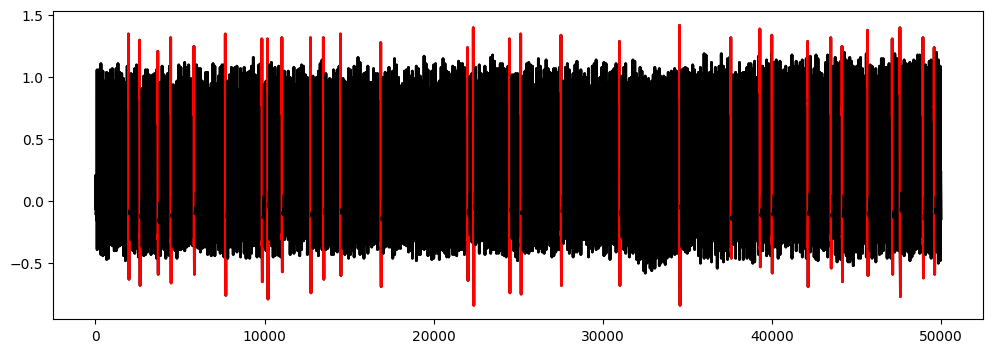

In [9]:
# How to load a dataset. For normality>1, add multiple time series files to the filenames list

filenames = [ECG]
df, normality, shift_idxs = load_dataset(filenames, sample_size=50000)


<h1>Evaluation Metrics / Save Results</h1>

In [11]:

output_path_base = path.join("OUTPUTS", "results")

def save_dict_to_json_file(dictionary, filename):
    makedirs(path.dirname(filename), exist_ok=True)
    
    with open(filename, 'w', encoding='utf-8') as json_file:
        json.dump(dictionary, json_file, indent=4, ensure_ascii=False)

        
def normalize_file_names(filenames: List[str]):
    filenames_norm = [filename[:filename.find('/')+1] for filename in filenames]
    filenames_norm = "_".join(filenames_norm)
    filenames_norm = re.sub(r'[^A-Za-z0-9_]', '.', filenames_norm)
    return filenames_norm
        
    
def get_json_file_path(filenames: List[str], normality: int, model_name: str, online: bool):
    filenames_norm = normalize_file_names(filenames)
    output_json = path.join(output_path_base, f"normality_{normality}", 
                            f"{filenames_norm}_{model_name}_{'online' if online else 'offline'}_{str(time.time())[-4:]}.json")
    return output_json


def results_file_exists(filenames: List[str], normality: int, model_name: str, online: bool):
    filenames_norm = normalize_file_names(filenames)
    output_json = pattern = path.join(output_path_base, f"normality_{normality}", 
            f"{filenames_norm}_{model_name}_{'online' if online else 'offline'}_*.json")
    # print(output_json)
    return glob.glob(output_json)
    

# save TSB report to a json file
def gather_TSB_results(model_name, online, label, score, slidingWindow, filenames, normality, elapsed_time, 
                       save_to_json=True, additional_stats=None):
    
    output_json = get_json_file_path(filenames, normality, model_name, online)
    results = printResult(None, label, score, slidingWindow, None, None)
    results = [float(value) for value in results]
    results = {
        "model": model_name,
        "online": online,
        "normality": normality,
        "datasets": filenames,
        "series_length": len(label),
        "window": int(slidingWindow),
        "AUC": results[0],
        "Precision": results[1],
        "Recall": results[2],
        "F": results[3],
        "Precision@k": results[9],
        "Rprecision": results[7],
        "Rrecall": results[4],
        "Rf": results[8],
        "ExistenceReward": results[5],
        "OverlapReward": results[6],
        "RAUC": results[10],
        "time": elapsed_time
    }
    if additional_stats is not None:
        results = {**results, **additional_stats}
    
    save_dict_to_json_file(results, output_json)
    return results



def gather_AELSTM_results(
    model_name:str, time_series_len:int, filenames:List[str], normality:int, AELSTMresults,
    label, scores, slidingWindow, elapsed_time, additional_stats= None):
    
    output_json = get_json_file_path(filenames, normality, model_name, True)
    TSBresults = printResult(None, label, scores, slidingWindow, None, None)
    TSBresults = [float(value) for value in TSBresults]

    results = {
        "model": model_name,
        "online": True,
        "normality": normality,
        "datasets": filenames,
        "series_length": time_series_len,
        "window": int(slidingWindow),
        "AUC": float(AELSTMresults['AUC']),
        "Precision": float(AELSTMresults['report']['anamoly']['precision']),
        "Recall": float(AELSTMresults['report']['anamoly']['recall']),
        "F": float(AELSTMresults['report']['anamoly']['f1-score']),
        "Precision@k": TSBresults[9],
        "Rprecision": TSBresults[7],
        "Rrecall": TSBresults[4],
        "Rf": TSBresults[8],
        "ExistenceReward": TSBresults[5],
        "OverlapReward": TSBresults[6],
        "RAUC": TSBresults[10],
        "Accuracy": float(AELSTMresults['Accuarcy']),
        "confusion_matrix": AELSTMresults['confusion matrix'].astype(int).tolist(),
        "time": elapsed_time
    }
    if additional_stats is not None:
        results = {**results, **additional_stats}
    
    save_dict_to_json_file(results, output_json)
    return results


<h1>SAND method</h1>
<h3>[Q5] Streaming baseline AD method</h3>

In [12]:

def SAND_model(df: pd.DataFrame, filenames: List[str], normality: int):
    
    name = "_".join(filenames)
    modelName='SAND'
    start_time = time.time()
    
    # process data
    data = df[0]
    label = df[1]
    slidingWindow = find_length(data)
    
    print("Estimated Subsequence length: ",slidingWindow)
    print("Time series length: ",len(data))
    print("Number of abnormal points: ",list(label).count(1))
    
    # train model 
    clf = SAND(pattern_length = slidingWindow, subsequence_length = 4*(slidingWindow))
    x = data
    clf.fit(x, online=True, alpha=0.5, init_length=5000, batch_size=5000, verbose=True, overlaping_rate=int(4*slidingWindow))
    
    # test
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    elapsed_time = time.time() - start_time
    # ! add ```plt.show()``` to utils/slidingWindow.py/plotFig to display plots
    plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
    
    # save results
    return gather_TSB_results(modelName, True, label, score, slidingWindow, filenames, normality, elapsed_time)


In [ ]:
# SAND_model(df, filenames, normality)

<h1>EncDec-AD </h1>
<h3>[Q4] Offline/Non-streaming baseline method</h3>
<p>LSTM Encoder/Decoder methodology - DeepADoTS implementation</p>
    

In [13]:

def EncDecAD_model(df: pd.DataFrame, filenames: List[str], normality: int, shift_idx: List[int]=None, online_mode=False):
    name = "_".join(filenames)
    modelName = "EncDec-AD"
    start_time = time.time()
    
    # prepare dataset
    X = df[[0]]
    Y = df[1]
    n_features = X.shape[1]
    slidingWindow = find_length(X[0])
    first_shift_idx = None if normality==1 or shift_idx is None else shift_idx[0]
    X_train, Y_train, X_val, Y_val, X_test, Y_test = separate_sets(X, Y, train_perc=0.2, val_perc=0, first_shift_idx=first_shift_idx)
    slidingWindow = min(slidingWindow, X_train.shape[0])
    print('sliding window = ', slidingWindow)

    # train
    p = len(str(slidingWindow)) - 1
    p = pow(10, p)
    batch_size = min(int(4 * (slidingWindow // p) * p), X_train.shape[0])
    model = EncDecAD(n_features = n_features,
                     hidden_size = 32,
                     sequence_length = slidingWindow,
                     gpu = device)
    model.fit(X_train, num_epochs=40, batch_size=batch_size)

    # test
    score, loss = model.predict(X_test, batch_size=batch_size)
    elapsed_time = time.time() - start_time
    
    if online_mode:
        return score, X_test, Y_test
    else:
        # show evaluation results
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        plotFig(X_test[0], Y_test, score, slidingWindow, fileName=name, modelName=modelName)
        return gather_TSB_results(modelName, online_mode, Y_test, score, slidingWindow, filenames, normality, elapsed_time)
    
    

In [ ]:
# EncDecAD_model(df, filenames, normality, shift_idx, online_mode=False)

<h1>EncDec-AD-Batch </h1>
<h3>[Q6] Naive streaming variant (1):<br> Offline method is applied to each batch of the data that arrives. No modification of the method itself.</h3>
<p>Offline method: LSTM Encoder/Decoder - DeepADoTS implementation</p>


In [14]:

def create_stream(df: pd.DataFrame, stream_batch_size: int = 10000) -> List[pd.DataFrame]:
    # first stream batch boundaries
    start = 0
    end = min(stream_batch_size, df.shape[0])

    stream = []
    while start <df.shape[0] and end <= df.shape[0]:
        stream_batch = df.iloc[start:end].reset_index(drop=True)
        stream.append(stream_batch)

        # move on to the next batch of the stream
        start += stream_batch_size
        end += stream_batch_size
        end = min(end, df.shape[0])

    # in case the last batch is smaller than the seq len, concat it with the previous batch
    sequence_len = find_length(stream[0][0])
    if stream[-1].shape[0] < sequence_len:
        stream[-2] = pd.concat([stream[-2], stream[-1]], ignore_index=True)
        stream = stream[:-1]
    return stream


In [15]:

def EncDecAD_Batch_model(df: pd.DataFrame, filenames: List[str], normality:int, stream_batch_size:int=10000):
    modelName = "EncDec-AD-Batch"
    stream = create_stream(df, stream_batch_size)
    start_time = time.time()

    # for gathering stream results
    score = np.empty(0)
    X_test = pd.DataFrame(columns=[0])
    Y_test = pd.Series(dtype=df[1].dtype)

    for i, batch in enumerate(stream):
        print(f"Batch {i+1}/{len(stream)} with # {batch.shape[0]} points")
        # apply non-streaming method on each batch independently
        batch_score, batch_X_test, batch_Y_test = EncDecAD_model(batch, filenames, normality, online_mode=True)

        # append batch results
        score = np.concatenate((score, batch_score), axis=0)
        X_test = pd.concat([X_test, batch_X_test], ignore_index=True)  # needed for plotFig func
        Y_test = pd.concat([Y_test, batch_Y_test], ignore_index=True)  # points used for training are excluded from testing

        # move on to the next branch
        
    # show evaluation results on the whole stream
    elapsed_time = time.time() - start_time
    sliding_window = find_length(df[0])
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    plotFig(X_test[0], Y_test, score, sliding_window, fileName="_".join(filenames), modelName=modelName)
    return gather_TSB_results(modelName, True, Y_test, score, sliding_window, filenames, normality, elapsed_time)



In [ ]:
# EncDecAD_Batch_model(df, filenames, normality, batch_size=int(df.shape[0] / 10))


<h1>EncDec-AD-Online </h1>
<h3>[Q6] Streaming variant 2: Streaming Anomaly Detection with Incremental Learning and Concept Drift Detection<br></h3>
<p>In the realm of time series anomaly detection, adapting to continuously arriving data points in a streaming setting is crucial for timely and accurate detection of anomalies. We propose an online adaptation of the EncDec-AD model, originally designed for offline detection using an LSTM autoencoder architecture. In our approach, the model is initially trained on a specified percentage of the initial data stream to establish a baseline. Subsequently, it undergoes incremental learning, updating its parameters in real-time as new data arrives. To address concept drift, which can significantly affect model performance, we integrate a Kolmogorov-Smirnov (KS) test to monitor reconstruction errors. This test detects significant changes in the error distribution, triggering a complete retraining of the model when necessary. Additionally, the anomaly score threshold is dynamic and determined by the theta-percentile, calculated with linear interpolation. This combination of initial training, incremental learning, and concept drift detection ensures that the EncDec-AD model remains accurate and responsive to changes in the data stream, making it well-suited for real-time anomaly detection in dynamic environments.
    
Summary:
<ul>
    <li>The EncDec-AD model (an LSTM Autoencoder) is initially trained using a percentage (train_perc) of the initial points in the data stream. </li> 
    <li>It is subsequently updated through incremental learning.</li> 
    <li>A concept drift detection mechanism monitors the model's predictions (reconstruction errors) and triggers the model to be retrained from scratch when significant changes are detected.</li> 
    <li>Dynamic annomaly score threshold determined by the theta-precentile.</li>
</ul>
</p>
    

In [16]:

class CapacityQueue:
    def __init__(self, queue_capacity, with_replacement=False):
        self.replaced_elements = None
        self.total_elements = None
        self.queue = None

        self.queue_capacity = queue_capacity  # Maximum capacity of the queue
        self.with_replacement = with_replacement
        self.reset()

    def __len__(self):
        return len(self.queue)

    def reset(self):
        self.queue = deque(maxlen=self.queue_capacity if self.with_replacement else None)  # Initialize deque with a fixed size
        self.total_elements = 0  # Total elements added
        self.replaced_elements = 0  # Number of elements replaced

    def push(self, x):
        if self.with_replacement and len(self.queue) == self.queue_capacity:
            # If the queue is full, increment replaced_elements
            self.replaced_elements += 1
        self.queue.append(x)
        self.total_elements += 1

    def isFull(self):
        return len(self.queue) >= self.queue_capacity

    def percentage_replaced(self):
        if self.total_elements < self.queue_capacity:
            return 0  # No replacement has occurred if the total elements added is less than capacity
        return (self.replaced_elements / self.total_elements) * 100

    def copy_from(self, other):
        self.queue = deque(other.queue, maxlen=other.queue_capacity)
        self.total_elements = other.total_elements
        self.replaced_elements = other.replaced_elements
        
# ======================================================================================================

class OnlineAD:

    def __init__(self,
                 df: pd.DataFrame,
                 filenames: List[str],
                 normality: int,
                 shift_idx: List[int] = None,
                 Wincrem: int = 1000, Wdrift: int = 200,
                 max_buffer_len: int = 2000,
                 incremental_cutoff: int = 50,
                 percentile_cutoff: int = 92,
                 ks_significance_level: float = 0.001,
                 training_epochs: int = 40,
                 incremental_training_epochs: int = 10,
                 use_increm_learning: bool = True,
                 use_concept_drift: bool = True,
                 verbose: int = 0
                 ):
        self.name = "OnlineEncDecAD"
        self.v = verbose
        self.training_epochs = training_epochs
        self.incremental_training_epochs = incremental_training_epochs
        self.max_buffer_len = max_buffer_len

        self.Wincrem = Wincrem
        self.Wdrift = Wdrift
        self.incremental_cutoff = incremental_cutoff
        self.percentile_cutoff = percentile_cutoff
        self.ks_significance_level = ks_significance_level

        self.X, self.Y = None, None
        self.sequence_length = None
        self.n_features = None
        self.model = None
        self.theta_t = None
        self.drift_idxs = []
        self.increm_idxs = []
        self.initialize(df, shift_idx)

        self.errors = []
        self.Y_hat = []
        self.pred_buffer= CapacityQueue(self.max_buffer_len)
        self.wnd_increm = CapacityQueue(self.Wincrem, True)
        self.wnd_drift  = CapacityQueue(self.Wdrift)
        self.wnd_ref    = CapacityQueue(self.Wdrift)

        start_time = time.time()
        self.parse_stream(use_increm_learning, use_concept_drift)
        self.get_predictions()
        self.elapsed_time = time.time() - start_time
        self.extract_results(filenames, normality, use_increm_learning, use_concept_drift)

    # -----------------------------------------------------------------------------------------------
  
    def initialize(self, df: pd.DataFrame, shift_idx: List[int]):
        X = df[[0]]
        Y = df[1]
        self.n_features = X.shape[1]

        # drift windows (Wdrift size) should be at least as large as the sequence
        self.sequence_length = find_length(X[0])
        if self.sequence_length > self.Wdrift:
            self.Wdrift = int(self.sequence_length)

        first_shift_idx = None if shift_idx is None or len(shift_idx)==0 else shift_idx[0]
        X_init_train, Y_init_train, _, _, self.X, self.Y = separate_sets(X, Y, train_perc=0.2, val_perc=0, first_shift_idx=first_shift_idx)
        print(f"Seq len = {self.sequence_length}\nInitializing model with {X_init_train.shape[0]} samples...")
        self.fit_model(X_init_train, True, 0)


    def fit_model(self, X: Union[pd.DataFrame, CapacityQueue], reset_model: bool, t:int):

        if reset_model:
            self.model = EncDecAD(
                n_features = self.n_features,
                hidden_size = 32,
                sequence_length = self.sequence_length,
                gpu = device)
            epochs = self.training_epochs
        else:
            epochs = self.incremental_training_epochs

        X = self.toDF(X)

        if self.v>=1: print(f"\nTraining model ({'from scratch' if reset_model else 'incremental'}) with {X.shape} samples")
        if reset_model: self.drift_idxs.append(t)
        else: self.increm_idxs.append(t)

        self.model.fit(X, epochs, batch_size = self.get_batch_size(X), show_progress_bar=(self.v>=2 or t==0))
        _, train_loss = self.model.predict(X)
        self.theta_t = self.calc_percentile(train_loss)

        if self.v>=1: print(f"New theta_t = {self.theta_t}\n{'-'*30}")


    def calc_percentile(self, loss):
        return np.percentile(loss, self.percentile_cutoff, interpolation='linear')



    def predict_model(self, X: Union[pd.DataFrame, CapacityQueue], is_output: bool):
        X = self.toDF(X)

        _, loss = self.model.predict(X, batch_size = self.get_batch_size(X))
        Y_hat = (loss > self.theta_t).astype(int)

        if is_output:
            self.errors.append(loss)
            self.Y_hat.append(Y_hat)

        return loss


    # -------------------------------------------------------------------------------------------------
    def parse_stream(self, use_increm_learning: bool, use_concept_drift: bool):

        print(f"Parse stream with #{self.X.shape[0]} data points...")
        for (t, xt) in self.X.iterrows():
            if self.v==0 and t%5000==0: print(f"{t} ->", end='')
            
            self.pred_buffer.push(xt)

            if self.pred_buffer.isFull():   
                if self.v>=2: print(f"Predict buffer (# {len(self.pred_buffer)}) since full")
                self.predict_model(self.pred_buffer, True)
                self.pred_buffer.reset()

            if self.X.shape[0] - t > self.sequence_length:  # at least one sequence should remain in the stream
                if use_increm_learning:
                    self.incremental_training(t, xt)
                if use_concept_drift:
                    self.concept_drift_detection(t, xt)

        if len(self.pred_buffer) > 0:
            print(f"\nPredict last buffer (# {len(self.pred_buffer)}) before finish")
            self.predict_model(self.pred_buffer, True)
            self.pred_buffer.reset()



    def incremental_training(self, t, xt):
        self.wnd_increm.push(xt)
        if self.wnd_increm.isFull() or self.wnd_increm.percentage_replaced() >= self.incremental_cutoff:

            if self.v>=2: print(f"Incremental training (# {len(self.wnd_increm)}) at t = {t}"); self.printObjects()

            self.fit_model(self.wnd_increm, False, t)
            self.wnd_increm.reset()



    def concept_drift_detection(self, t, xt):
        if not self.wnd_ref.isFull():
            self.wnd_ref.push(xt)
        elif not self.wnd_drift.isFull():
            self.wnd_drift.push(xt)
        else:
            ref_loss = self.predict_model(self.wnd_ref, False)
            drift_loss = self.predict_model(self.wnd_drift, False)
            drift_detected = self.check_for_drift(ref_loss, drift_loss, t)

            if drift_detected:
                if self.v>=2:
                    print(f"Drift detected at t = {t}")
                    self.printObjects()

                if len(self.pred_buffer) > self.sequence_length:
                    if self.v>=2: print(f"Predict buffer (# {len(self.pred_buffer)})  before drift reset step")
                    self.predict_model(self.pred_buffer, True)
                    self.pred_buffer.reset()

                self.fit_model(self.wnd_drift, True, t)
                self.wnd_ref.reset()
                self.wnd_drift.reset()
                self.wnd_increm.reset()
            else:
                self.wnd_ref.copy_from(self.wnd_drift)
                self.wnd_drift.reset()
                if self.v>=2:
                    print(f"No Drift at t = {t}"); self.printObjects()



    def check_for_drift(self, ref_loss: np.ndarray, drift_loss: np.ndarray, t:int):
        """:return: 
            True:  The two distributions are significantly different (reject H0).
            False: The two distributions are not significantly different (fail to reject H0).
        """""
        ks_statistic, p_value = ks_2samp(ref_loss.ravel(), drift_loss.ravel())
        if self.v>=2: print(f"Checked for drift p-value = {p_value} at t = {t}")
        return p_value < self.ks_significance_level


    # -------------------------------------------------------------------------------------------------

    def toDF(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        elif isinstance(X, CapacityQueue):
            return pd.DataFrame(X.queue)
        else:
            ValueError(f"Invalid x type: {type(X)}")


    def get_batch_size(self, X):
        data_len = X.shape[0] if isinstance(X, pd.DataFrame) else len(X)
        p = len(str(self.sequence_length)) - 1
        p = pow(10, p)
        batch_size = min(int(4 * (self.sequence_length // p) * p), data_len)
        return batch_size

    def get_predictions(self):
        self.errors = np.concatenate(self.errors, axis=1).ravel()
        self.Y_hat  = np.concatenate(self.Y_hat, axis=1).ravel()
        
        
    def results(self):
        
        target_names = ['normal', 'anamoly']
        print("Accuarcy: " + str(accuracy_score(self.Y, self.Y_hat)))
        print("AUC: " + str(roc_auc_score(self.Y, self.Y_hat)))
        print("AUC PR: " + str(average_precision_score(self.Y, self.Y_hat)))
        print(confusion_matrix(self.Y, self.Y_hat))
        print(classification_report(self.Y, self.Y_hat, target_names=target_names, digits=4))

        return {'name': self.name,
                'Accuarcy': str(accuracy_score(self.Y, self.Y_hat)),
                'AUC': str(roc_auc_score(self.Y, self.Y_hat)),
                'AUC PR': str(average_precision_score(self.Y, self.Y_hat)),
                'confusion matrix': confusion_matrix(self.Y, self.Y_hat),
                'report': (classification_report(self.Y, self.Y_hat, target_names=target_names, digits=4, output_dict=True))}

    
    def extract_results(self, filenames, normality, use_increm_learning, use_concept_drift):
        results = self.results()
        additional_stats = {
            "use_increm_learn": use_increm_learning,
            "use_drift_detect": use_concept_drift,
            "increm_idxs": self.increm_idxs,
            "drift_idxs": self.drift_idxs,
            "ks_significance": self.ks_significance_level,
            "percentile": self.percentile_cutoff
        }
        print(additional_stats)
        results = gather_AELSTM_results(self.name, self.X.shape[0], 
                              filenames, normality, results, 
                              self.Y, self.Y_hat, self.sequence_length, self.elapsed_time, additional_stats)
        plotFig(self.X[0], self.Y, self.Y_hat.astype(float), self.sequence_length, fileName="_".join(filenames), modelName=self.name)
    
    # -------------------------------------------------------------------------------------------------

    def printObjects(self, message= None):
        print(f"\twnd_ref : # {len(self.wnd_ref)}\t {message}")
        print(f"\twnd_drift : # {len(self.wnd_drift)}")
        print(f"\twnd_incre : # {len(self.wnd_increm)}")
        print(f"\tpred_buff : # {len(self.pred_buffer)}")
        
        

In [ ]:
# model = OnlineAD(df, filenames, normality, verbose=0)

<h1>AE-LSTM (Online/Streaming) </h1>
<h3>[Q6] Streaming variant 2: Online model sourced from GitHub to serve as an additional baseline</h3>
<p>LSTM Autoencoder methodology - redsofa (official) implementation</p>


In [17]:

# helper functions from original repo (OnlineAnomalyDetection.py):

def get_file_stream(data_source, target_column):
    if target_column == None:
        stream = FileStream(data_source, allow_nan=True, n_targets=0)
    else:
        stream = FileStream(data_source, allow_nan=True, n_targets=1, target_idx=target_column)
    return stream


def genericDetectorSteps(_detector, data_source, target_column, max_samples, batch_size):
    """
    This function include the general steps for an algorithm to detect anomaly for streaming data.
    predict_and_update() will be different based on the class type.
    :param _detector: The detected algorithm we are going to use
    :param data_source: The dataset link 
    :param batch_size: size of data to send to algorithm to each iteration for anomaly detection
    :param max_samples: maximum number of samples sent
    :param timestamp_column: column name in the data source which represents timestamp
    :param target_column: column name in the data source which represents target column
    :return: detector object
    """    
    _detector.stream = get_file_stream(data_source, target_column)
    _detector.start_time = time.time()

    if _detector.isPretrain:
        _detector.pre_train(_detector.isSupervised)
    else:
        # if not pretrain, skip these data
        _detector.get_next_stream(_detector.initial_batch_training_size)

    while _detector.n_samples < max_samples and _detector.stream.has_more_samples():
        # For LSTM, we need to get next sequence instead of data
        X, y = _detector.get_next_sequence(batch_size)
        _detector.predict_and_update(X,y)

    _detector.end_time = time.time()
    return _detector

# run AE-LSTM Online AD model: =======================================================================


def LSTMOnline_model(
    df: pd.DataFrame,
    filenames: List[str],
    normality: int,
    initial_batch_training_size:int,
    neurons:int = 32,
    epochs:int = 30,
    target_column_idx:int = 1
):
    model_name = 'AE-LSTM'
    # save dataframe to a csv (temporarily)
    def prepare_dataset_dataframe() -> str:
        filenames_norm = [filename[:filename.find('/')+1] for filename in filenames]
        filenames_norm = re.sub(r'[^A-Za-z0-9_]',  '.',  "_".join(filenames))
        new_data_source = os.path.join("OUTPUTS", 'temp_dataframes', filenames_norm + "_converted.csv")
        os.makedirs(os.path.dirname(new_data_source), exist_ok=True)
        df.to_csv(new_data_source, index=False)
        return new_data_source
    
    max_samples = df.shape[0]
    new_data_source = prepare_dataset_dataframe()
    
    slidingWindow = find_length(df[0])
    p = len(str(slidingWindow)) - 1
    p = pow(10, p)
    batch_size = min(int(4 * (slidingWindow // p) * p), max_samples)
    
    # define model
    LSTM_model = LSTMOnline(name = model_name, 
        detector = AELSTMOnline(time_steps = int(slidingWindow), 
                                neurons = neurons, 
                                epochs = epochs, 
                                anomaly_rate = 30, 
                                n_batch = batch_size),
        data_source = new_data_source, 
        initial_batch_training_size = initial_batch_training_size,
        batch_size = batch_size, 
        max_samples = max_samples, 
        timestamp_column = None, 
        target_column = target_column_idx,
        isSupervised = False, 
        ifSaveResult = True, 
        isPretrain = True)
    
    # training
    start_time = time.time()
    LSTM_model = genericDetectorSteps(
        LSTM_model, new_data_source, target_column_idx, max_samples, batch_size)
    K.clear_session()
    
    # delete temporary file
    os.remove(new_data_source)
    
    # make predictions and show results
    results = LSTM_model.results()
    y_pred = np.array(LSTM_model.y_pred)
    label = df[1][initial_batch_training_size:].values
    elapsed_time = time.time() - start_time
    
    gather_AELSTM_results(model_name, df.shape[0], filenames, normality, results, label, y_pred, slidingWindow, elapsed_time)
    plotFig(df[0], label, y_pred, slidingWindow, fileName=new_data_source, modelName=model_name)
    
    return LSTM_model, y_pred, results


In [ ]:
# model, y_pred, results = LSTMOnline_model(df, filenames, initial_batch_training_size=1000)


In [18]:
import traceback

SAND_ = "SAND"
ENC_DEC_AD_OFFLINE = "EncDec-AD"
ENC_DEC_AD_BATCH = "EncDec-AD-Batch"
ENC_DEC_AD_ONLINE = "OnlineEncDecAD"
AE_LSTM_ONLINE = "AE-LSTM"

def run_model_for_sets(model_name, sets: Union[List[str], List[List[str]]], check_if_results_exist:bool=False):
    failed_sets = []
    for i, filename in enumerate(sets):
        try:
            filenames = [filename] if isinstance(filename, str) else filename
            print(f"Set [{i}] = {filenames}")
            
            sample_size = 100000 if len(filenames)==1 else 50000
            df, normality, shift_idxs = load_dataset(filenames, sample_size=sample_size, plot_series=False)
            
            if check_if_results_exist:
                results_file = results_file_exists(filenames, normality, model_name, model_name not in [ENC_DEC_AD_OFFLINE])
                if results_file:
                    print(f"Results file already exists {results_file}. Skip", '\n', '-'*50, '\n')
                    continue
            
            if model_name == SAND_:
                results = SAND_model(df, filenames, normality)
                
            elif model_name == ENC_DEC_AD_OFFLINE:
                results = EncDecAD_model(df, filenames, normality, shift_idxs, online_mode=False)
                
            elif model_name == ENC_DEC_AD_BATCH:
                stream_batch_size = int(df.shape[0] / 10)
                results = EncDecAD_Batch_model(df, filenames, normality, stream_batch_size)
            
            elif model_name == ENC_DEC_AD_ONLINE:
                results = OnlineAD(df, filenames, normality, shift_idxs, verbose=0)
                
            elif model_name == AE_LSTM_ONLINE:
                _,_,results = LSTMOnline_model(df, filenames, normality, initial_batch_training_size=1000)
                
            print(results, '\n', '-'*50, '\n')
        except Exception as e:
            failed_sets.append(filename)
            print(f"{filename} failed")
            traceback.print_exc()
        time.sleep(60)
            
    return failed_sets


<h1>Normality 1 Experiments</h1>

In [24]:
# normality 1 data info
get_datasets_info(sample_size=100000)

,Series,length,# anomalies,# normal,anomaly rate
8,Daphnet,28800,1547,27253,5.37
0,Dodgers,50400,5612,44788,11.13
1,ECG,100000,4650,95350,4.65
9,GHL,100000,144,99856,0.14
10,Genesis,16220,50,16170,0.31
2,IOPS,100000,465,99535,0.46
3,KDD21,79795,620,79175,0.78
4,MGAB,100000,200,99800,0.20
11,MITDB,100000,1397,98603,1.40
5,NAB,2499,246,2253,9.84


In [ ]:
run_model_for_sets(SAND_, ALL_SETS)

In [ ]:
run_model_for_sets(ENC_DEC_AD_OFFLINE, ALL_SETS)

In [ ]:
run_model_for_sets(ENC_DEC_AD_BATCH, ALL_SETS)

In [ ]:
run_model_for_sets(ENC_DEC_AD_ONLINE, ALL_SETS)

In [ ]:
run_model_for_sets(AE_LSTM_ONLINE, ALL_SETS)

<h1>Normality 2 Experiments</h1>

- Reject datasets that all or the majority of models showed low performance in normality 1 tests
- Get all combinations (size 2)/possible pairs for the remaining datasets (combinations not permutations)
- Sample at most 50k initial data points from the beginning of each series.
- Training for Offline EncDec-AD and initial training for Online EncDec-AD was performed on the initial 20% of points of the first series in the concatenated series.

In [19]:
from itertools import permutations, combinations

norm2sets = ALL_SETS.copy()
for low_perf_norm1_set in [DAPHNET, DODGERS, MITDB, 
                           OCCUPANCY, SVDB, KDD21]:
    # norm2sets.remove(low_perf_norm1_set)
    pass
    
norm2sets = [list(pair) for pair in list(combinations(norm2sets, 2))]
print(len(norm2sets))
# norm2sets = random.sample(norm2sets, k=10)
norm2sets

120


[['Dodgers/101-freeway-traffic.test.out', 'ECG/MBA_ECG803_data.out'],
 ['Dodgers/101-freeway-traffic.test.out',
  'IOPS/KPI-1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0.test.out'],
 ['Dodgers/101-freeway-traffic.test.out',
  'KDD21/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.out'],
 ['Dodgers/101-freeway-traffic.test.out', 'MGAB/1.test.out'],
 ['Dodgers/101-freeway-traffic.test.out', 'NAB/NAB_data_Traffic_1.out'],
 ['Dodgers/101-freeway-traffic.test.out', 'SensorScope/stb-2.test.out'],
 ['Dodgers/101-freeway-traffic.test.out', 'YAHOO/Yahoo_A1real_1_data.out'],
 ['Dodgers/101-freeway-traffic.test.out', 'Daphnet/S01R02E0.test.csv@1.out'],
 ['Dodgers/101-freeway-traffic.test.out',
  'GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.test.csv@4.out'],
 ['Dodgers/101-freeway-traffic.test.out',
  'Genesis/genesis-anomalies.test.csv@1.out'],
 ['Dodgers/101-freeway-traffic.test.out', 'MITDB/100.test.csv@1.out'],
 ['Dodgers/101-freeway-traffic.test.out',
  'OPPORTUNITY/S1-ADL1.test.csv@16.out'],
 ['Dod

In [25]:
get_k_normality_info(norm2sets, sample_size=50000)

,Series,length,# anomalies,# normal,anomaly rate
92,Daphnet_GHL_,28800_50000_,1547_144_,27253_49856_,5.37_0.29_
93,Daphnet_Genesis_,28800_16220_,1547_50_,27253_16170_,5.37_0.31_
94,Daphnet_MITDB_,28800_50000_,1547_359_,27253_49641_,5.37_0.72_
95,Daphnet_OPPORTUNITY_,28800_50000_,1547_1128_,27253_48872_,5.37_2.26_
96,Daphnet_Occupancy_,28800_8143_,1547_1729_,27253_6414_,5.37_21.23_
97,Daphnet_SMD_,28800_28479_,1547_2694_,27253_25785_,5.37_9.46_
98,Daphnet_SVDB_,28800_50000_,1547_26071_,27253_23929_,5.37_52.14_
7,Dodgers_Daphnet_,50000_28800_,5326_1547_,44674_27253_,10.65_5.37_
0,Dodgers_ECG_,50000_50000_,5326_2325_,44674_47675_,10.65_4.65_
8,Dodgers_GHL_,50000_50000_,5326_144_,44674_49856_,10.65_0.29_


In [ ]:
run_model_for_sets(SAND_, norm2sets)

In [ ]:
run_model_for_sets(ENC_DEC_AD_OFFLINE, norm2sets)

In [ ]:
run_model_for_sets(ENC_DEC_AD_BATCH, norm2sets)

In [ ]:
run_model_for_sets(ENC_DEC_AD_ONLINE, norm2sets, True)

12
Set [0] = ['ECG/MBA_ECG803_data.out', 'MGAB/1.test.out']
Series len = 100000
Normality = 2
Distro shift indexes = [50000]
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
Accuarcy: 0.9455252525252525
AUC: 0.6418737470938436
AUC PR: 0.07097350682779069
[[92837  3778]
 [ 1615   770]]
              precision    recall  f1-score   support

      normal  

AE-LSTM drift detected...
AE-LSTM start traning
Accuarcy: 0.9551671266482674
AUC: 0.507617003675803
AUC PR: 0.018474769637824136
[[62245  1797]
 [ 1127    51]]
              precision    recall  f1-score   support

      normal     0.9822    0.9719    0.9771     64042
     anamoly     0.0276    0.0433    0.0337      1178

    accuracy                         0.9552     65220
   macro avg     0.5049    0.5076    0.5054     65220
weighted avg     0.9650    0.9552    0.9600     65220

{'name': 'AE-LSTM', 'Accuarcy': '0.9551671266482674', 'AUC': '0.507617003675803', 'AUC PR': '0.018474769637824136', 'confusion matrix': array([[62245,  1797],
       [ 1127,    51]], dtype=int64), 'report': {'normal': {'precision': 0.9822161206842138, 'recall': 0.9719402891852222, 'f1-score': 0.9770511874676252, 'support': 64042}, 'anamoly': {'precision': 0.027597402597402596, 'recall': 0.0432937181663837, 'f1-score': 0.03370786516853932, 'support': 1178}, 'accuracy': 0.9551671266482674, 'macro avg': {'preci

AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift dete

AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start 

[]

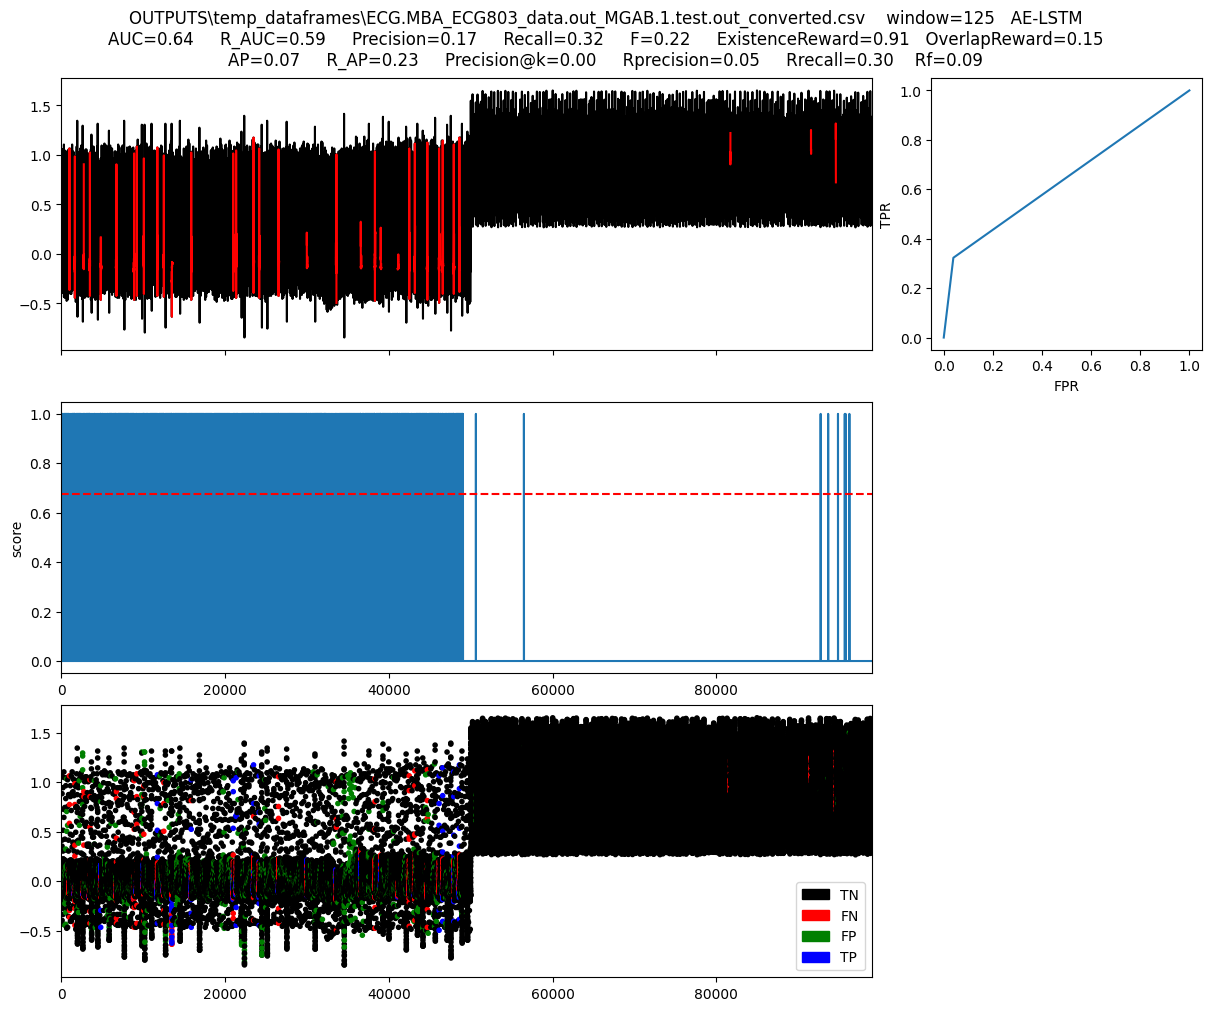

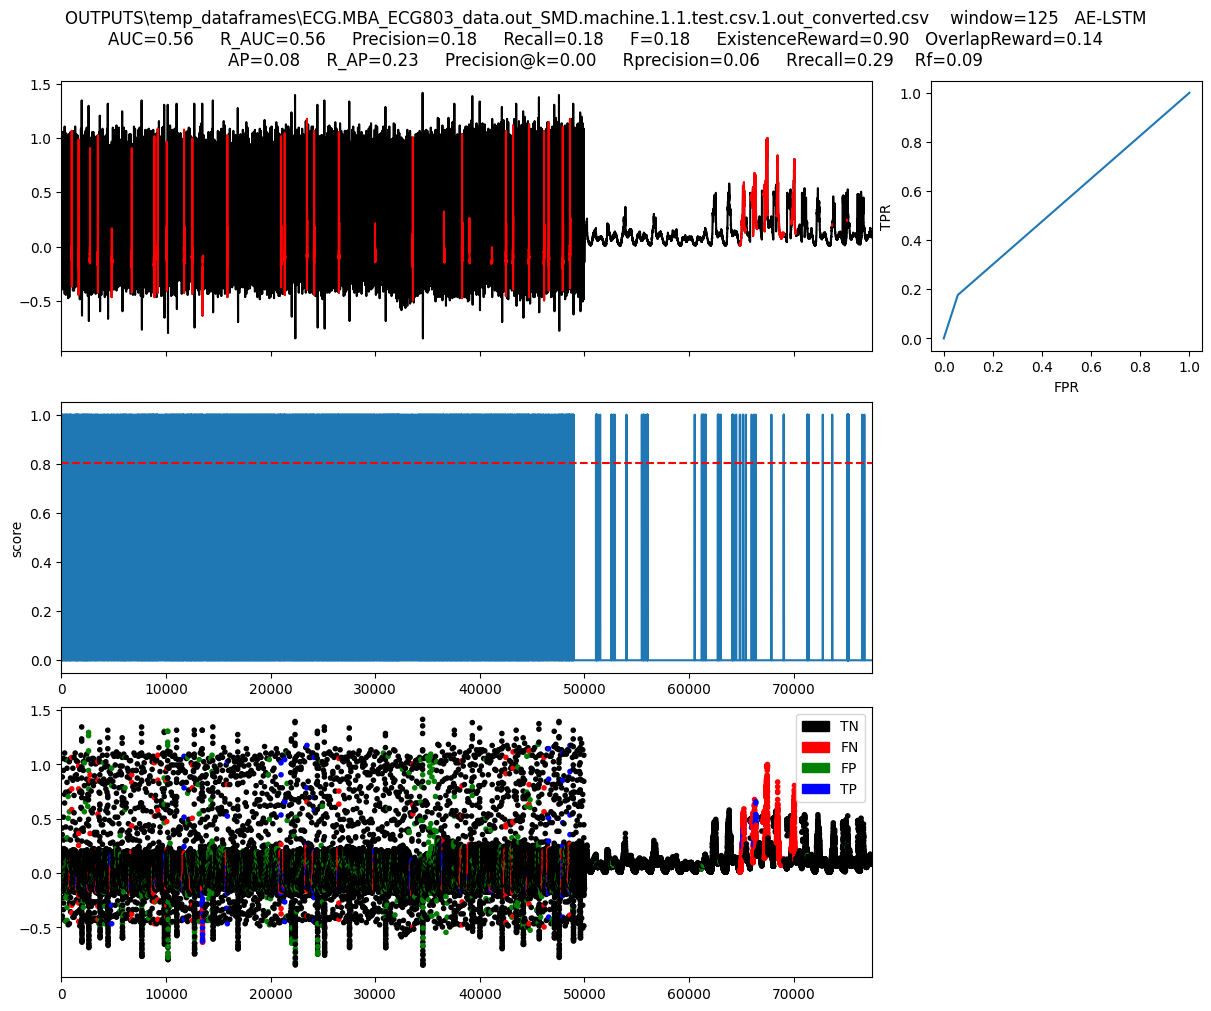

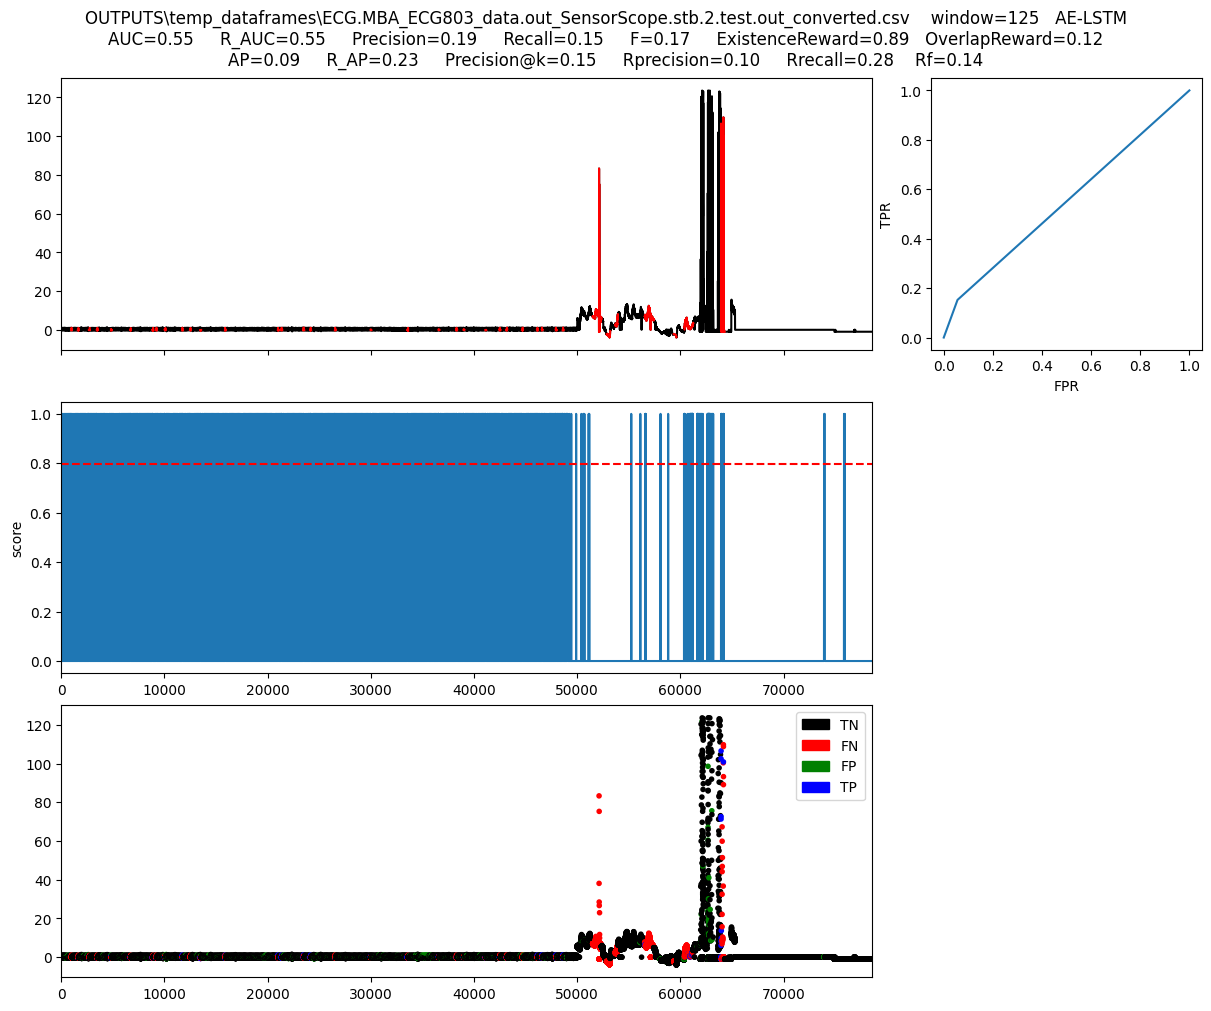

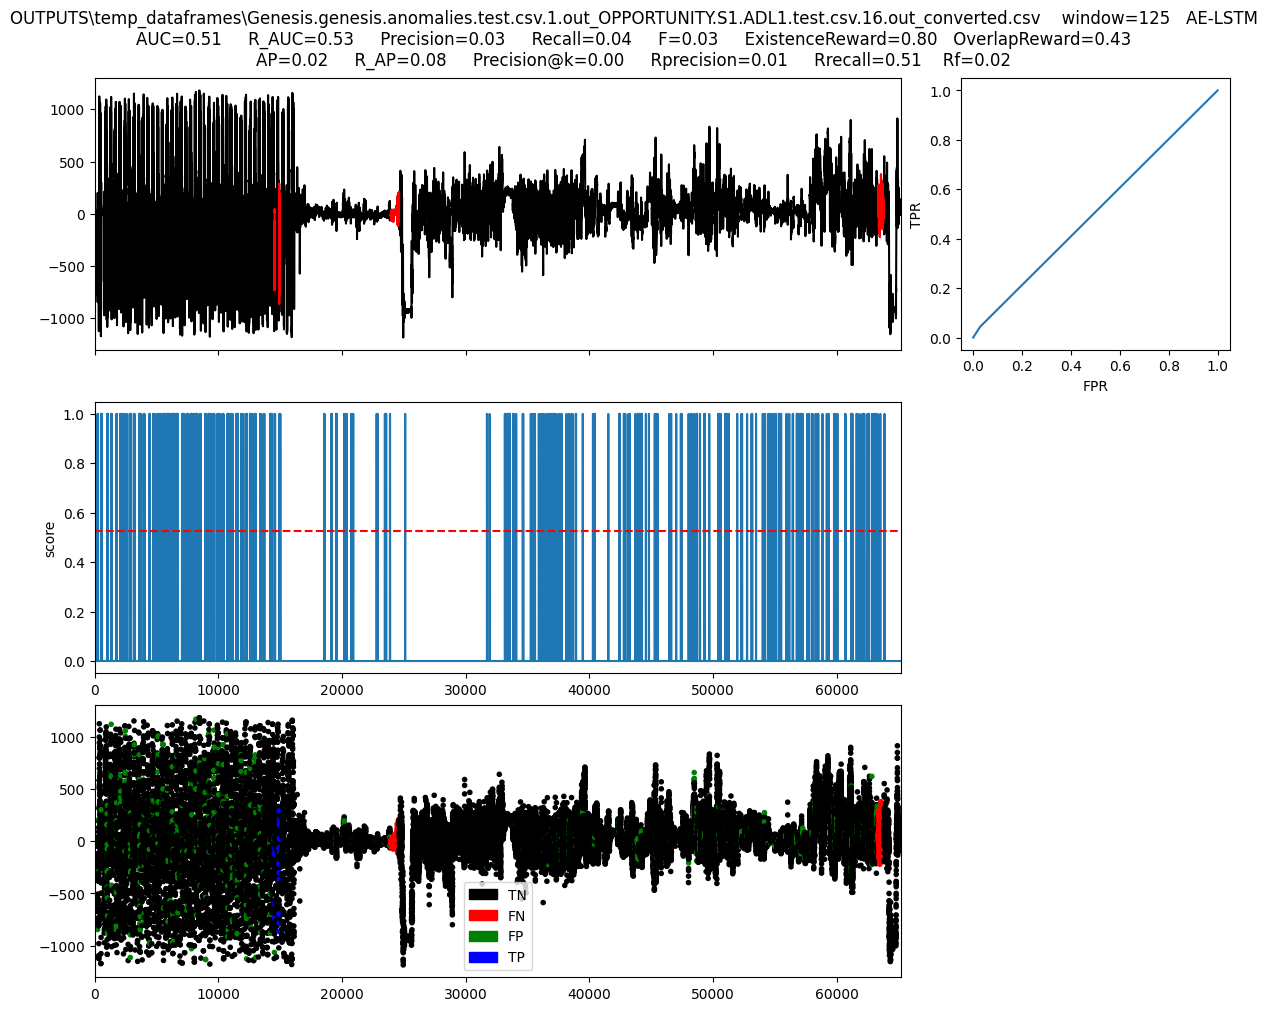

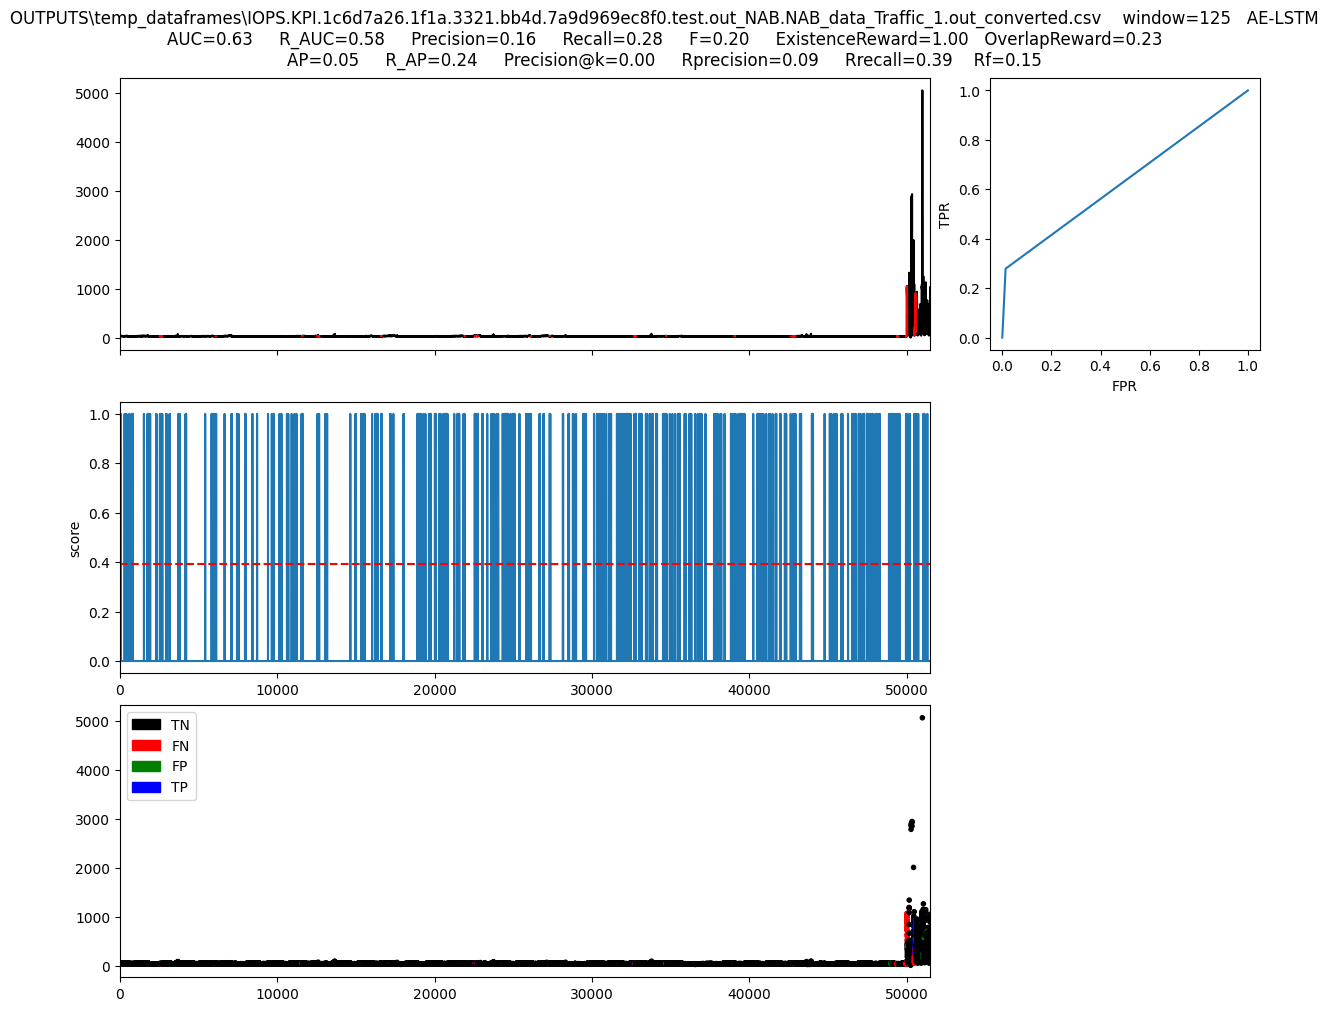

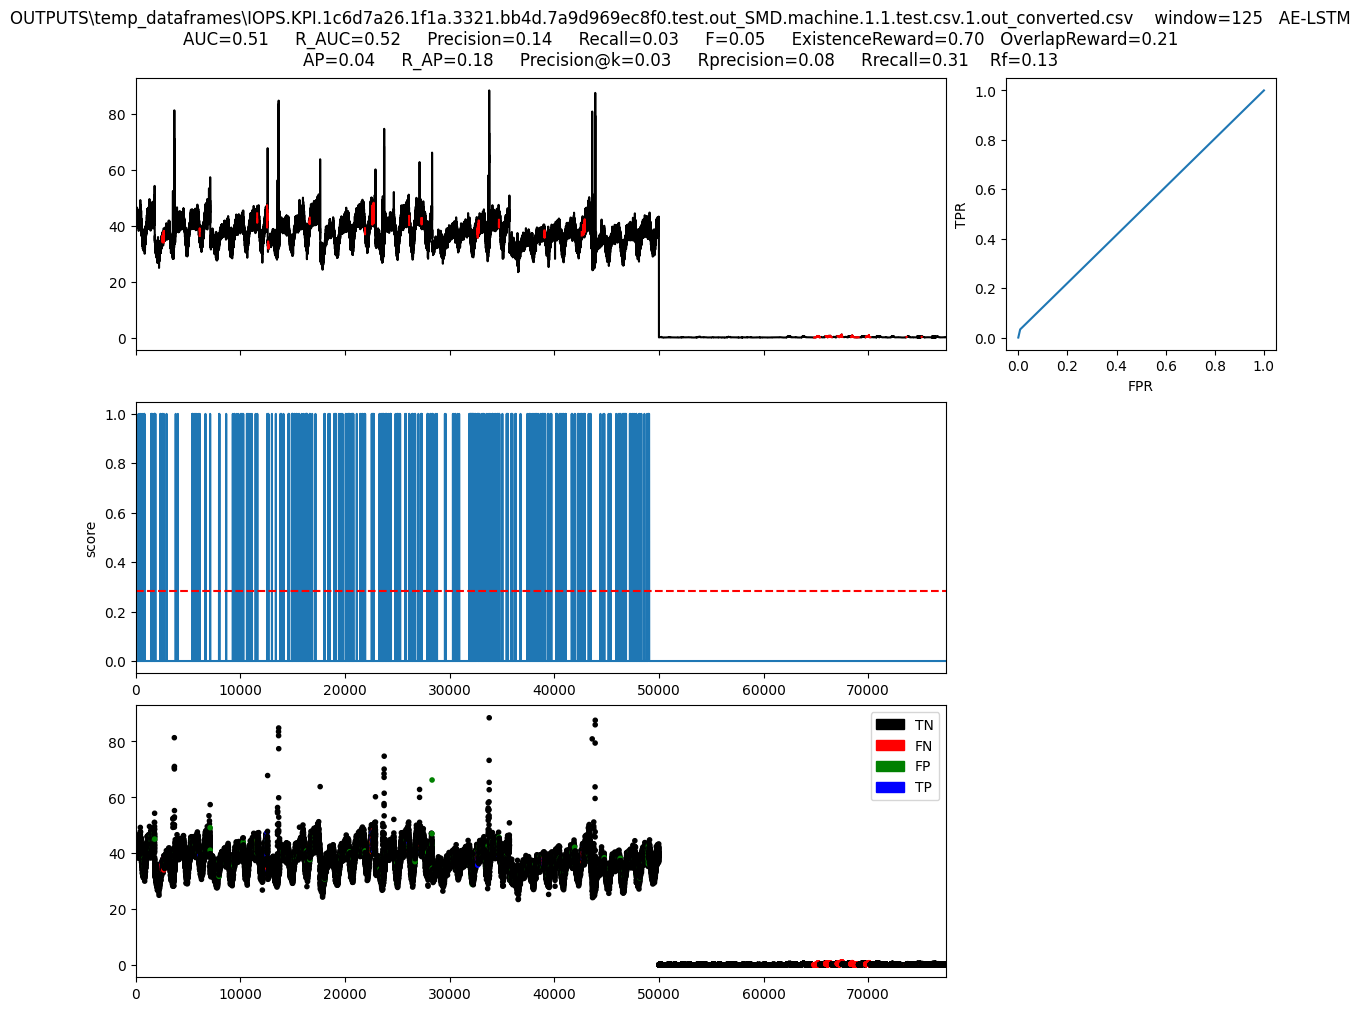

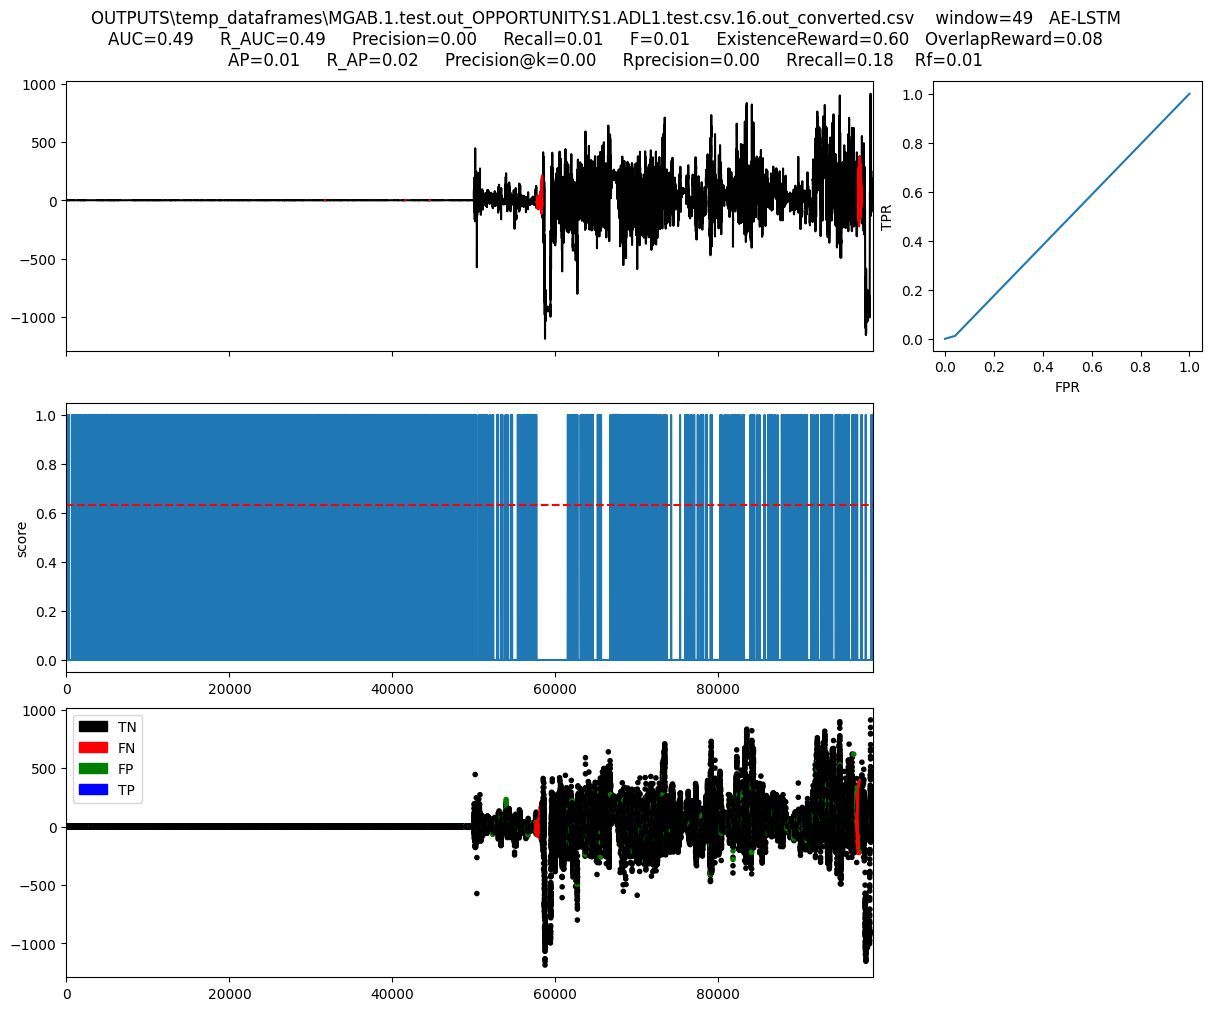

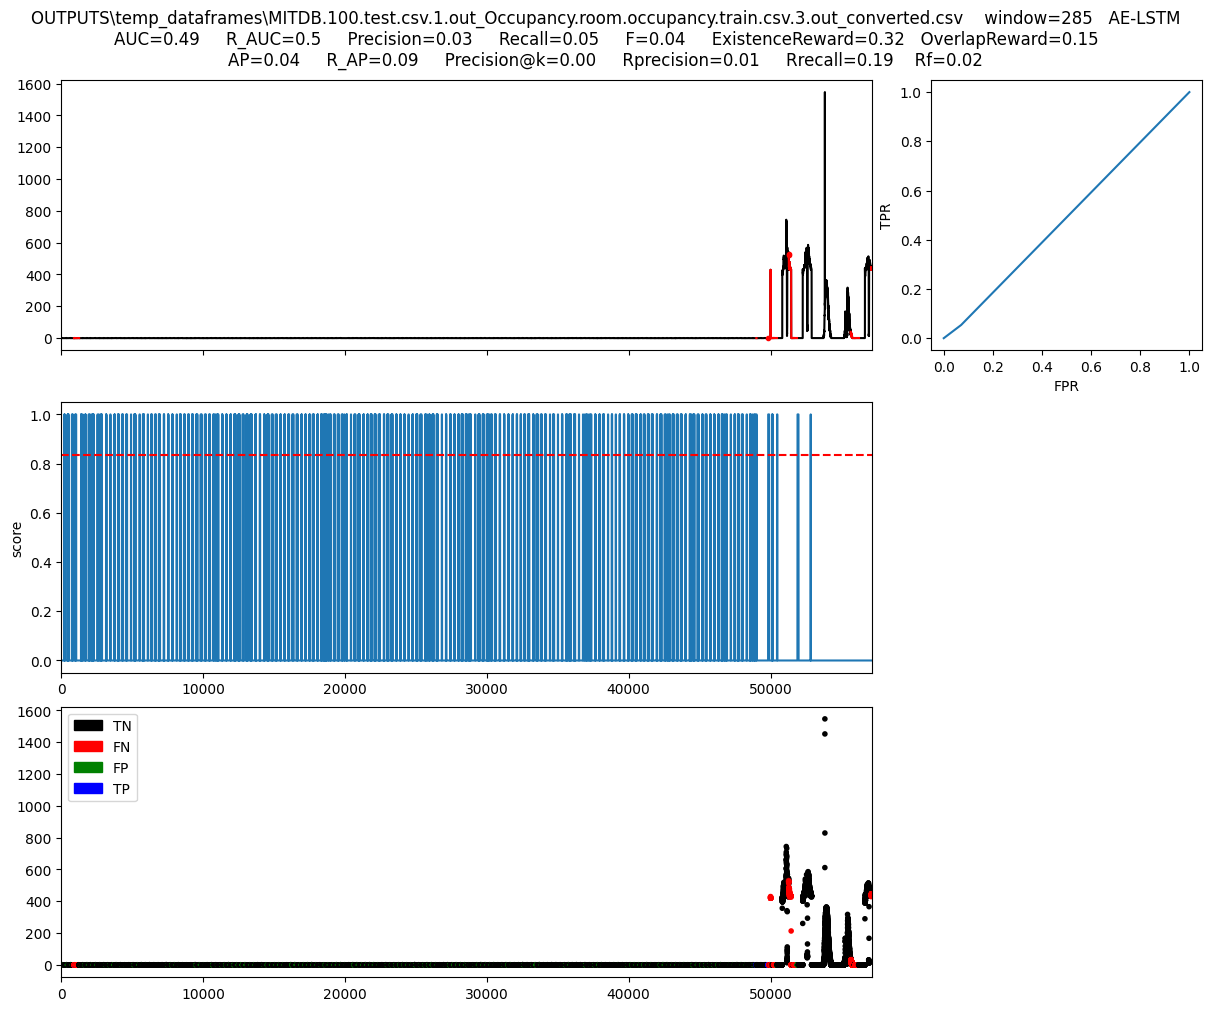

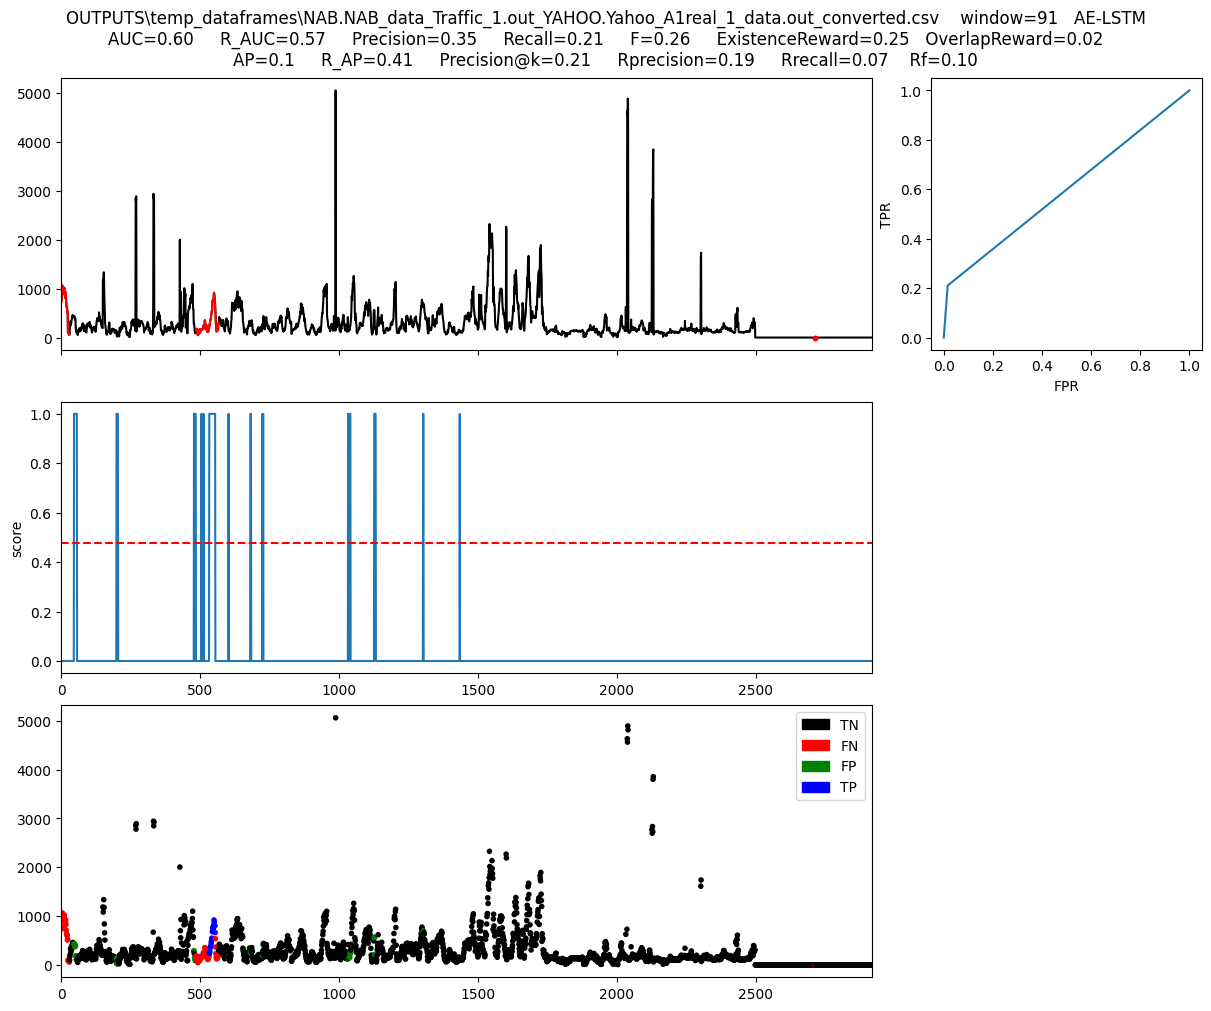

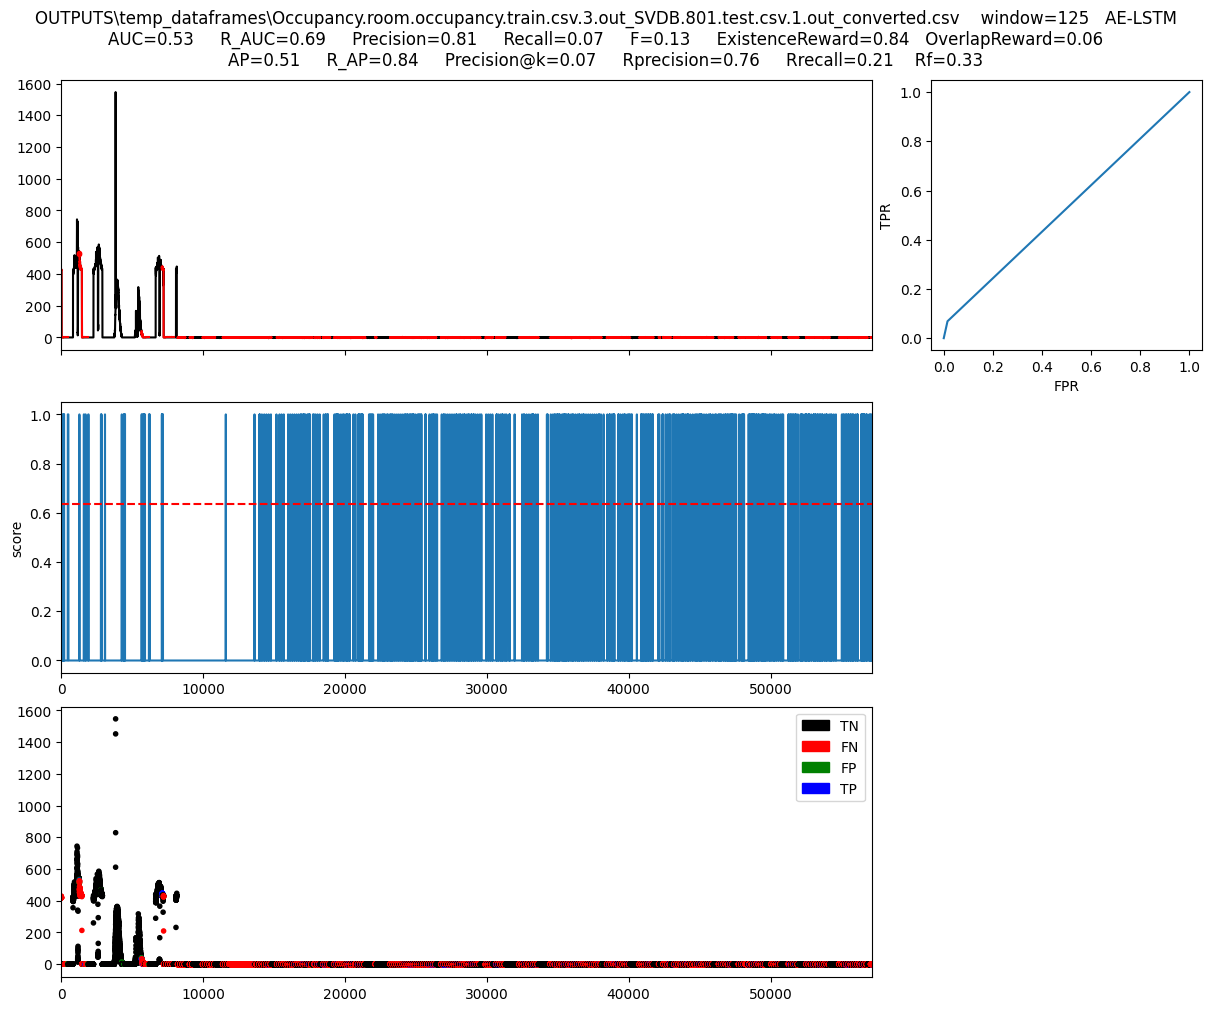

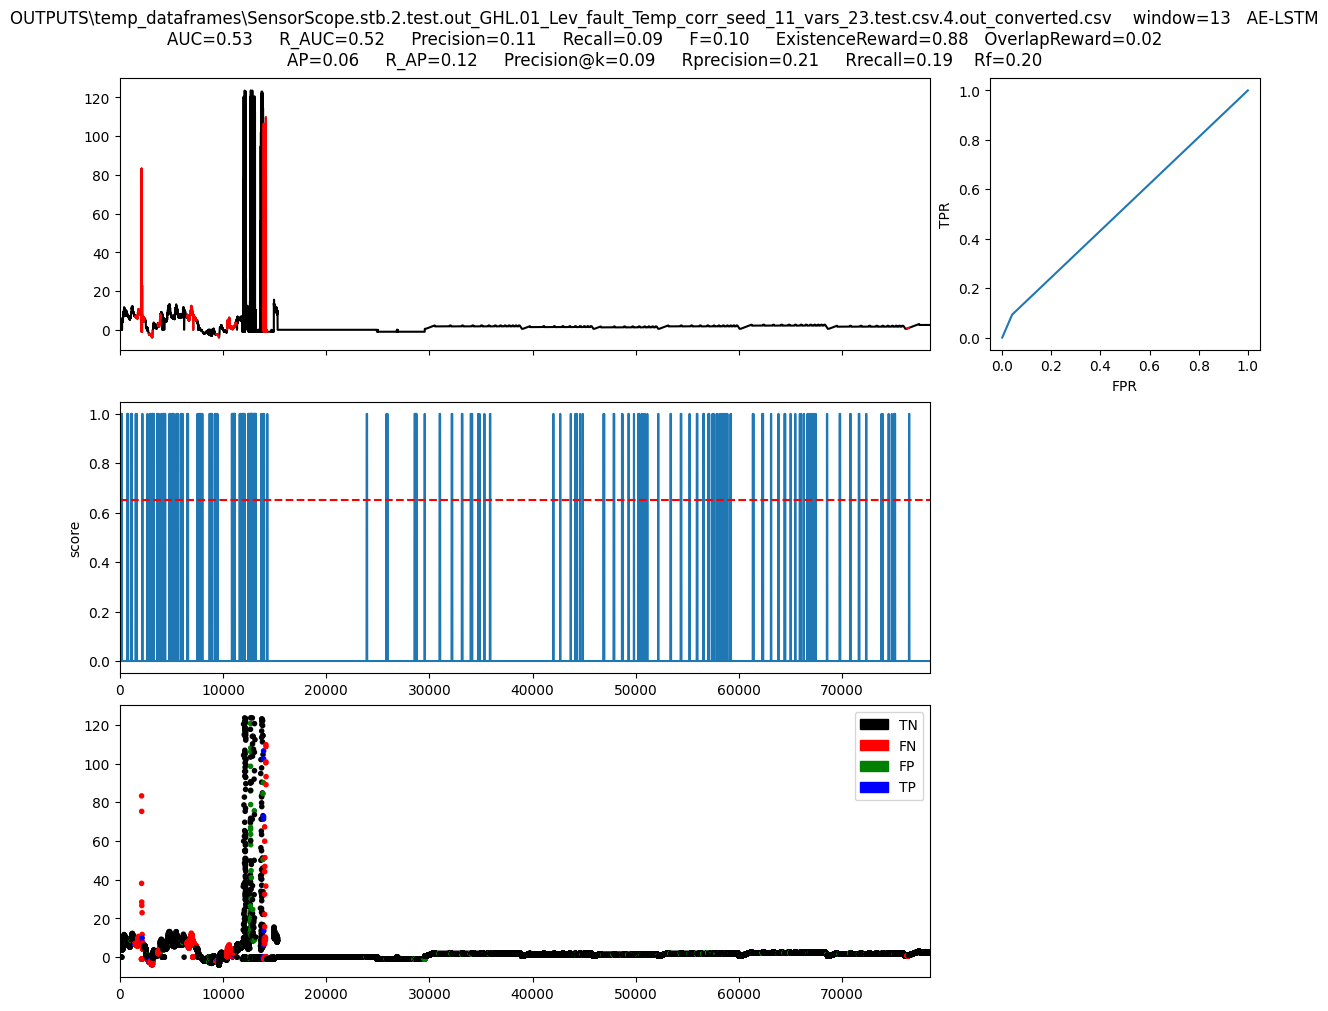

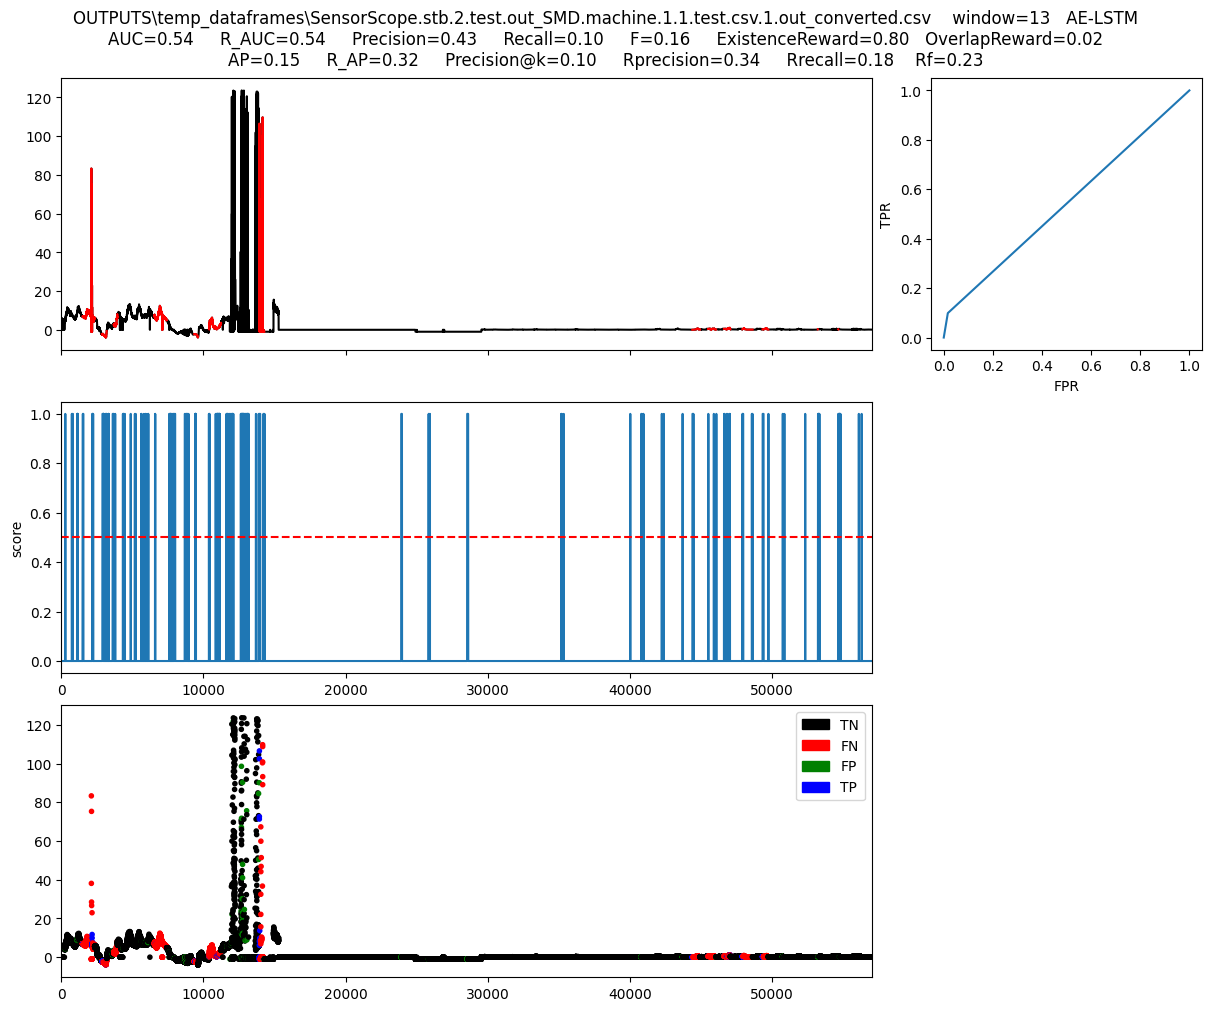

In [20]:
selected_norm2 = [
    [ECG, MGAB],[ECG, SMD],[ECG, SENSORSCOPE],[GENESIS, OPPORTUNITY],[IOPS, NAB],[IOPS, SMD],
    [MGAB, OPPORTUNITY],[MITDB,OCCUPANCY],[NAB, YAHOO], [OCCUPANCY,SVDB],[SENSORSCOPE,GHL],
    [SENSORSCOPE,SMD]]
print(len(selected_norm2))
run_model_for_sets(AE_LSTM_ONLINE, selected_norm2)